In [1]:
import numpy as np
import pickle
from tqdm import tqdm, tqdm_notebook
import random
import time
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import PIL
from PIL import Image
from sklearn.neighbors import NearestNeighbors
import random
from textwrap import wrap

import glob
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib notebook

In [2]:
# Helper function to get the classname
def classname(str):
    return str.split('/')[-2]

In [3]:
def display(dic, per_class, neighbors, message):
    for key in dic:
        print(key, "\tAccuracy: ", per_class[key])
    for each_class in dic:
        indices_of_class = [
            i for i, j in enumerate(filenames) if classname(j) == each_class
        ]
        random_image_index = random.choice(indices_of_class)
        distances, indices = neighbors.kneighbors(
            [feature_list[random_image_index]])
        similar_image_paths = [filenames[random_image_index]] + \
            [filenames[indices[0][i]] for i in range(1, 4)]
        plot_images(similar_image_paths, distances[0], message)

In [4]:
def get_least_accurate_classes(feature_list):
    per_class_acc = {}
    num_nearest_neighbors = 5
    num_correct_predictions = 0
    num_incorrect_predictions = 0
    neighbors = NearestNeighbors(n_neighbors=num_nearest_neighbors,
                                 algorithm='brute',
                                 metric='euclidean').fit(feature_list)
    for i in tqdm_notebook(range(len(feature_list))):
        distances, indices = neighbors.kneighbors([feature_list[i]])
        for j in range(1, num_nearest_neighbors):
            predicted_class = classname(filenames[indices[0][j]])
            ground_truth = classname(filenames[i])
            if (predicted_class not in per_class_acc):
                per_class_acc[predicted_class] = [0, 0, 0]
            if ground_truth == predicted_class:
                num_correct_predictions += 1
                per_class_acc[predicted_class][0] += 1
                per_class_acc[predicted_class][2] += 1
            else:
                num_incorrect_predictions += 1
                per_class_acc[predicted_class][1] += 1
                per_class_acc[predicted_class][2] += 1
    print(
        "Accuracy is ",
        round(
            100.0 * num_correct_predictions /
            (1.0 * num_correct_predictions + num_incorrect_predictions), 2))
    for key, value in per_class_acc.items():
        per_class_acc[key] = round(100.0 * value[0] / (1.0 * value[2]), 2)
    dic = sorted(per_class_acc, key=per_class_acc.get)

    # least_accurate classes
    print("\n\nTop 10 incorrect classifications\n")
    for key in dic[:10]:
        print(key, "\tAccuracy: ", per_class_acc[key])
    return dic[:6], per_class_acc

In [6]:
# Load dataset features
filenames = pickle.load(open('data/filenames-caltech101.pickle', 'rb'))
feature_list = pickle.load(open('data/features-caltech101-mobilenet.pickle', 'rb'))
class_ids = pickle.load(open('data/class_ids-caltech101.pickle', 'rb'))

In [7]:
# Perform PCA over the features
# set the number of features intended
num_feature_dimensions = 100
pca = PCA(n_components=num_feature_dimensions)
pca.fit(feature_list)
feature_list = pca.transform(feature_list)

We are using the classes with the least accuracy because the effect of finetuning is expected be most pronounced on these categories.

In [8]:
names_of_least_accurate_classes_before_finetuning, accuracy_per_class_before_finetuning = get_least_accurate_classes(
    feature_list[:])

C:\Users\P Chiranjeeva Kumar\anaconda3\lib\site-packages\ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':



Accuracy is  100.0


Top 10 incorrect classifications

datasets 	Accuracy:  100.0


Print names of the least accurate classes before fine-tuning

In [9]:
names_of_least_accurate_classes_before_finetuning

['datasets']

Combine the features from the 6 least accurate classes into a list so that we can use this list for further experiments and visualization.

In [10]:
least_accurate_feature_list = []
least_accurate_filenames = []
least_accurate_count = {}
for index, filename in enumerate(filenames):
    if classname(filename) not in least_accurate_count:
        least_accurate_count[classname(filename)] = 0
    if classname(
            filename
    ) in names_of_least_accurate_classes_before_finetuning and least_accurate_count[
            classname(filename)] <= 50:
        least_accurate_feature_list.append(feature_list[index])
        least_accurate_count[classname(filename)] += 1
        least_accurate_filenames.append(class_ids[index])


Train t-SNE only on the 6 least accurate classes.

In [11]:
from sklearn.manifold import TSNE
selected_features = least_accurate_feature_list
selected_class_ids = least_accurate_filenames
selected_filenames = least_accurate_filenames
time_start = time.time()
tsne_results = TSNE(n_components=2, verbose=1,
                    metric='euclidean').fit_transform(selected_features)
# tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=250, metric=’euclidean’)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time() - time_start))

[t-SNE] Computing 50 nearest neighbors...
[t-SNE] Indexed 51 samples in 0.000s...
[t-SNE] Computed neighbors for 51 samples in 0.000s...
[t-SNE] Computed conditional probabilities for sample 51 / 51
[t-SNE] Mean sigma: 0.138402
[t-SNE] KL divergence after 250 iterations with early exaggeration: 51.248844
[t-SNE] KL divergence after 1000 iterations: 0.504572
t-SNE done! Time elapsed: 0.6573951244354248 seconds


<IPython.core.display.Javascript object>


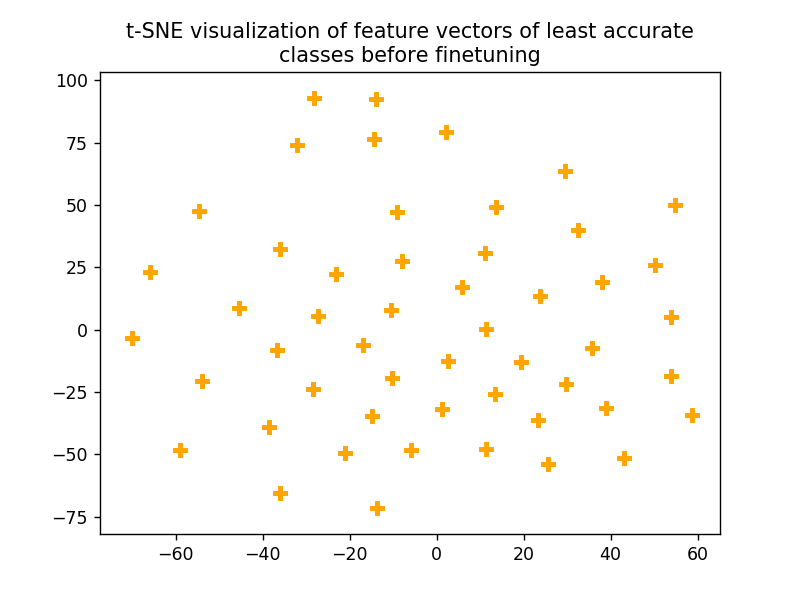

In [12]:
plt.title("\n".join(
    wrap(
        "t-SNE visualization of feature vectors of least accurate classes before finetuning",
        60)))
set_classes = list(set(selected_class_ids))
# set different markers for all the classes we are going to show
markers = ["^", ".", "s", "o", "x", "P"]
# set different colors for all the classes we are going to show
colors = ['red', 'blue', 'fuchsia', 'green', 'purple', 'orange']
class_to_marker = {}
class_to_color = {}
for index in range(len(tsne_results)):
    # assign color and marker to each type of class
    if selected_class_ids[index] not in class_to_marker:
        class_to_marker[selected_class_ids[index]] = markers.pop()
    if selected_class_ids[index] not in class_to_color:
        class_to_color[selected_class_ids[index]] = colors.pop()
    plt.scatter(tsne_results[index, 0],
                tsne_results[index, 1],
                c=class_to_color[selected_class_ids[index]],
                marker=class_to_marker[selected_class_ids[index]],
                edgecolor='white',
                linewidth='.6',
                s=90)
plt.show()

In [38]:
# from tensorflow.keras.applications.mobilenet import MobileNet,preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.applications.resnet50 import ResNet50,preprocess_input

In [25]:
batch_size=64
TRAIN_SAMPLES = 8677
NUM_CLASSES = 101
IMG_WIDTH, IMG_HEIGHT = 224, 224
root_dir = 'datasets/caltech101'

In [27]:
def model_picker(name):
    if (name == 'vgg16'):
        model = VGG16(weights='imagenet',
                      include_top=False,
                      input_shape=(224, 224, 3),
                      pooling='max')
    elif (name == 'vgg19'):
        model = VGG19(weights='imagenet',
                      include_top=False,
                      input_shape=(224, 224, 3),
                      pooling='max')
    elif (name == 'mobilenet'):
        model = MobileNet(weights='imagenet',
                          include_top=False,
                          input_shape=(224, 224, 3),
                          pooling='max',
                          depth_multiplier=1,
                          alpha=1)
    elif (name == 'inception'):
        model = InceptionV3(weights='imagenet',
                            include_top=False,
                            input_shape=(224, 224, 3),
                            pooling='max')
    elif (name == 'resnet'):
        model = ResNet50(weights='imagenet',
                         include_top=False,
                         input_shape=(224, 224, 3),
                        pooling='max')
    elif (name == 'xception'):
        model = Xception(weights='imagenet',
                         include_top=False,
                         input_shape=(224, 224, 3),
                         pooling='max')
    else:
        print("Specified model not available")
    return model

In [40]:
model_architecture = 'resnet'
model = model_picker(model_architecture)

In [18]:

train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                   rotation_range=20,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   zoom_range=0.2)

In [21]:
train_generator = train_datagen.flow_from_directory(root_dir,
                                                    target_size=(IMG_WIDTH,
                                                                 IMG_HEIGHT),
                                                    batch_size=batch_size,
                                                    shuffle=True,
                                                    seed=12345,
                                                    class_mode='categorical')

Found 6411 images belonging to 63 classes.


In [41]:
def model_maker():
    base_model = ResNet50(include_top=False,
                           input_shape=(IMG_WIDTH, IMG_HEIGHT, 3))
    for layer in base_model.layers[:]:
        layer.trainable = False
    input = Input(shape=(IMG_WIDTH, IMG_HEIGHT, 3))
    custom_model = base_model(input)
    custom_model = GlobalAveragePooling2D()(custom_model)
    custom_model = Dense(64, activation='relu')(custom_model)
    custom_model = Dropout(0.5)(custom_model)
    predictions = Dense(NUM_CLASSES, activation='softmax')(custom_model)
    return Model(inputs=input, outputs=predictions)

In [42]:
model_finetuned = model_maker()


C:\Users\P Chiranjeeva Kumar\anaconda3\lib\site-packages\keras_applications\resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [44]:
import tensorflow
model_finetuned.compile(loss='categorical_crossentropy',
              optimizer=tensorflow.keras.optimizers.Adam(0.001),
              metrics=['acc'])

In [45]:
import math
model_finetuned.fit_generator(
    train_generator,
    steps_per_epoch=math.ceil(float(TRAIN_SAMPLES) / batch_size),
    epochs=10)

Epoch 1/10


ValueError: A target array with shape (64, 63) was passed for an output of shape (None, 101) while using as loss `categorical_crossentropy`. This loss expects targets to have the same shape as the output.